# Constructing nx graphs from cross-ref CUI pairs

In [1]:
import pandas as pd
import networkx as nx
from pathlib import Path
import json
from tqdm import tqdm
import pickle

from collections import defaultdict

from matplotlib import pyplot as plt

from joblib import delayed, Parallel

import numpy as np

In [34]:
from gensim.models import Word2Vec

  0%|                                                                                                                                 | 0/34 [16:47<?, ?it/s]


## Opening data

In [2]:
pmids_cooc_expd_df = pd.read_pickle(
    '../benchmark_data/04_cross_ref_cui_pairs_pmid_ts/pmids_cooc_expd_df.pkl'
)

In [3]:
pmids_cooc_expd_df

,abstr_lvl_cooc,pair,date,from_ctd,from_gwas,from_drugcentral,from_mentha,from_rxnav,from_stringdb,from_kegg,from_disgennet,source,target
0,68,C0048581 C0134796,1975-11,False,False,False,False,False,False,True,False,C0048581,C0134796
0,68,C0017725 C0043047,1975-11,False,False,False,False,False,False,True,False,C0017725,C0043047
1,107,C0003818 C0302583,1975-10,False,False,False,False,False,False,True,False,C0003818,C0302583
1,107,C0009968 C0024706,1975-10,False,False,False,False,False,False,True,False,C0009968,C0024706
1,107,C0023175 C0043047,1975-10,False,False,False,False,False,False,True,False,C0023175,C0043047
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7202663,36475470,C0009241 C0338656,2022-12,False,False,False,False,False,False,False,True,C0009241,C0338656
7202663,36475470,C0038454 C0338656,2022-12,False,False,False,False,False,False,False,True,C0038454,C0338656
7202663,36475470,C0009241 C0948008,2022-12,False,False,False,False,False,False,False,True,C0009241,C0948008
7202663,36475470,C0038454 C0948008,2022-12,False,False,False,False,False,False,False,True,C0038454,C0948008


## Split `pmids_cooc_expd_df` for parallel processing in ascending order (years-based)

In [4]:
ts_dfs_output_path = Path(
    '../benchmark_data/05_cui_pairs_ts_nx/ts_dfs/'
)

ts_dfs_output_path.mkdir(parents=True, exist_ok=True)

In [5]:
min_year = 1990
max_year = 2023

In [9]:
year_ts_list = [f"{s}-01" for s in range(min_year, max_year + 1)]
year_ts_list

['1990-01',
 '1991-01',
 '1992-01',
 '1993-01',
 '1994-01',
 '1995-01',
 '1996-01',
 '1997-01',
 '1998-01',
 '1999-01',
 '2000-01',
 '2001-01',
 '2002-01',
 '2003-01',
 '2004-01',
 '2005-01',
 '2006-01',
 '2007-01',
 '2008-01',
 '2009-01',
 '2010-01',
 '2011-01',
 '2012-01',
 '2013-01',
 '2014-01',
 '2015-01',
 '2016-01',
 '2017-01',
 '2018-01',
 '2019-01',
 '2020-01',
 '2021-01',
 '2022-01',
 '2023-01']

In [10]:
for year in tqdm(year_ts_list):
    year_save = year.replace('-', '_')
    save_fname = f"{year_save}_pmids_cooc_expd_df.pkl"
    save_fpath = ts_dfs_output_path.joinpath(save_fname)
    if not save_fpath.exists():
        ts_df = (
            pmids_cooc_expd_df[
                pmids_cooc_expd_df['date'] <= year
            ]
        )
        ts_df.to_pickle(save_fpath)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:09<00:00,  3.64it/s]


## Creating temporal graph snapshots

### Aggregate dataframes (to add pair weight)

In [14]:
ts_dfs_flist = sorted(ts_dfs_output_path.glob('*.pkl'))
len(ts_dfs_flist)

34

In [22]:
def make_agg_df(fpath, out_dir):
    ts_df = pd.read_pickle(fpath)
    
    agg_df = (
        ts_df[['source', 'target', 'abstr_lvl_cooc']]
            .groupby(['source', 'target'])
            .agg(set)
    )
    
    agg_df['weight'] = agg_df['abstr_lvl_cooc'].apply(len)
    
    # saving
    out_fpath = out_dir.joinpath('agg_' + fpath.name)
    
    agg_df.to_pickle(out_fpath)
    
    return out_fpath

In [23]:
ts_dfs_agg_output_path = Path(
    '../benchmark_data/05_cui_pairs_ts_nx/ts_dfs_agg/'
)

ts_dfs_agg_output_path.mkdir(parents=True, exist_ok=True)

In [24]:
# memory intensive (~200 GB RAM for 8 threads)

with Parallel(n_jobs=8, batch_size=1) as parallel:
    pmid_title_records = parallel(
        delayed(make_agg_df)(i, ts_dfs_agg_output_path) for i in tqdm(ts_dfs_flist)
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [01:38<00:00,  2.91s/it]
/lustre/acslab/users/2288/anaconda3/envs/agatha_cgp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Convert dataframes to `networkx` networks

In [29]:
mTermsDict_fpath = Path('../benchmark_data/00_helper_data/cui_to_pref_name_dict.pkl')

In [26]:
agg_dfs_flist = sorted(
    Path('../benchmark_data/05_cui_pairs_ts_nx/ts_dfs_agg/')
    .glob('*.pkl')
)
len(agg_dfs_flist)

34

In [30]:
def agg_df_to_nx(fpath, out_dir, mTermsDict_fpath):
    
    aff_df = pd.read_pickle(fpath)
    
    graph_df = aff_df['weight'].to_frame().reset_index()
    
    mTermsDict = pd.read_pickle(mTermsDict_fpath)
    
    mTermsDict_def = defaultdict(str)
    mTermsDict_def.update(mTermsDict)

    graph_df['source_umls'] = graph_df['source'].apply(
        lambda x: mTermsDict_def[x.lower()]
    )
    graph_df['target_umls'] = graph_df['target'].apply(
        lambda x: mTermsDict_def[x.lower()]
    )

    graph_df['source_dec'] = graph_df['source'] + '__' + graph_df['source_umls']
    graph_df['target_dec'] = graph_df['target'] + '__' + graph_df['target_umls']

    graph_nx = nx.from_pandas_edgelist(
        graph_df,
        'source_dec', 'target_dec', 
        edge_attr='weight'
    )
    
    out_fname = '_'.join(fpath.stem.split('_')[1:3]) + '_nx.pkl'
    
    with open(out_dir.joinpath(out_fname), 'wb') as f:
        pickle.dump(graph_nx, f)
    
    return out_fname

In [28]:
ts_nx_graphs_out_path = Path('../benchmark_data/05_cui_pairs_ts_nx/ts_nx_graphs/')
ts_nx_graphs_out_path.mkdir(parents=True, exist_ok=True)

In [33]:
# memory intensive (~100 GB RAM for 16 threads)

with Parallel(n_jobs=16) as parallel:
    res = parallel(
        delayed(agg_df_to_nx)(
            i,
            ts_nx_graphs_out_path,
            mTermsDict_fpath
        ) for i in tqdm(agg_dfs_flist)
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:13<00:00,  2.47it/s]
/lustre/acslab/users/2288/anaconda3/envs/agatha_cgp/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


### Adding w2v node features

In [35]:
w2v_dir = Path('../DATA_INDEPENDENT/umls_embeddings/w2v_gensim_ts/')
w2v_model_list = sorted(list(w2v_dir.glob('*_model/*_epoch_9*.w2v')))
len(w2v_model_list)

34

In [36]:
ts_nx_dir = Path('../benchmark_data/05_cui_pairs_ts_nx/ts_nx_graphs/')
ts_nx_flist = sorted(list(ts_nx_dir.glob('*.pkl')))
len(ts_nx_flist)

34

In [37]:
years_range = [fname.stem.split('_')[0] for fname in w2v_model_list]
years_range

['1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023']

In [102]:
tx_graphs_n2v_nx_dict = dict()

for idx, year in enumerate(tqdm(years_range)):
    
    nx_fname = ts_nx_flist[idx]
    w2v_fname = w2v_model_list[idx]

    assert str(year) in str(nx_fname)
    assert str(year) in str(w2v_fname)

    ts_graph = pd.read_pickle(nx_fname)
    w2v_model = Word2Vec.load(str(w2v_fname))

    for node in ts_graph.nodes:
        cui = node.split('__')[0]

        if cui in w2v_model.wv:
            ts_graph.nodes[node]['w2v_emb'] = w2v_model.wv[cui]

    tx_graphs_n2v_nx_dict[year] = ts_graph

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [03:05<00:00,  5.46s/it]


#### Checking embeddings consistency

In [103]:
non_existent_embs = defaultdict(list)

for year in tx_graphs_n2v_nx_dict:
    for node in tx_graphs_n2v_nx_dict[year].nodes:
        if 'w2v_emb' not in tx_graphs_n2v_nx_dict[year].nodes[node]:
            non_existent_embs[year].append(node)

In [104]:
non_existent_embs

defaultdict(list,
            {'2021': ['C1566348__PIK3CB protein, human',
              'C5392920__Opioid Misuse',
              'C1454315__APLN protein, human',
              'C5433525__ACE2 protein, human',
              'C5441735__TDO2 protein, human',
              'C5392833__Acute Ischemic Stroke',
              'C5401281__PSG1 wt Allele',
              'C5392068__PD-L1 Inhibitors',
              'C1744226__MLANA protein, human',
              'C5389369__Multisystem inflammatory syndrome in children',
              'C0676309__Leucine-Rich Repeat Protein SHOC-2, Human',
              'C5244027__Pneumonia caused by SARS-CoV-2',
              'C0050459__acetophenone',
              'C5243563__Hormone receptor positive breast cancer',
              'C5441771__Retinoid X Receptor, human',
              'C5447987__eprenetapopt',
              'C5392067__Immune Checkpoint Blockade',
              'C5243945__Paradoxical psoriasis',
              'C5392069__CTLA-4 Inhibitors',
           

In [105]:
# we adding a w2v embedding for each missing concept as a centroid of embeddings of its neighbors 

for year in non_existent_embs:
    for missing_w2v_concept in non_existent_embs[year]:
        
        neighs_dict = dict()
        for neigh, neigh_attrs in dict(tx_graphs_n2v_nx_dict[year][missing_w2v_concept]).items():

            neighs_dict[neigh] = {
                'weight': neigh_attrs['weight'],
                'w2v': tx_graphs_n2v_nx_dict[year].nodes[neigh]['w2v_emb']
            }
            
        centroid_emb = np.zeros_like(list(neighs_dict.values())[0]['w2v'])

        denom = 0

        for neigh in neighs_dict:
            centroid_emb += neighs_dict[neigh]['weight'] * neighs_dict[neigh]['w2v']
            denom += neighs_dict[neigh]['weight']

        centroid_emb = centroid_emb/denom
        
        tx_graphs_n2v_nx_dict[year].nodes[missing_w2v_concept]['w2v_emb'] = centroid_emb
        

In [106]:
non_existent_embs = defaultdict(list)

for year in tx_graphs_n2v_nx_dict:
    for node in tx_graphs_n2v_nx_dict[year].nodes:
        if 'w2v_emb' not in tx_graphs_n2v_nx_dict[year].nodes[node]:
            non_existent_embs[year].append(node)

non_existent_embs

defaultdict(list, {})

#### Saving combined graphs

In [109]:
save_path = '../benchmark_data/06_cui_graph_ts_w2v_nx'

save_path = Path(save_path)
save_path.mkdir(parents=True, exist_ok=True)

In [110]:
for year in tqdm(tx_graphs_n2v_nx_dict):
    save_fname = f"{year}_pubmed_w2v_nx.pkl"
    
    pd.to_pickle(
        tx_graphs_n2v_nx_dict[year],
        save_path.joinpath(save_fname)
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [01:03<00:00,  1.87s/it]


## Plotting graph size over time

In [4]:
save_path = '../benchmark_data/06_cui_graph_ts_w2v_nx'

save_path = Path(save_path)

save_flist = sorted(save_path.glob('*.pkl'))
save_flist[:3]

[PosixPath('../benchmark_data/06_cui_graph_ts_w2v_nx/1990_pubmed_w2v_nx.pkl'),
 PosixPath('../benchmark_data/06_cui_graph_ts_w2v_nx/1991_pubmed_w2v_nx.pkl'),
 PosixPath('../benchmark_data/06_cui_graph_ts_w2v_nx/1992_pubmed_w2v_nx.pkl')]

In [5]:
tx_graphs_n2v_nx_dict = dict()

for fname in tqdm(save_flist):
    key = fname.stem.split('_')[0]
    
    tx_graphs_n2v_nx_dict[key] = pd.read_pickle(fname)

100%|███████████████████████████████████████████████████████████████████████████████| 34/34 [00:47<00:00,  1.38s/it]


In [24]:
tx_graphs_size_dict = dict()

for yr in tx_graphs_n2v_nx_dict:
    yr_int = int(yr) - 1
    tx_graphs_size_dict[yr_int] = {
        'nodes': len(tx_graphs_n2v_nx_dict[yr].nodes),
        'edges': len(tx_graphs_n2v_nx_dict[yr].edges),
    }

In [25]:
tx_graphs_size_df = pd.DataFrame(tx_graphs_size_dict).T

Text(0.5, 1.0, 'Number of nodes in $G$ over time')

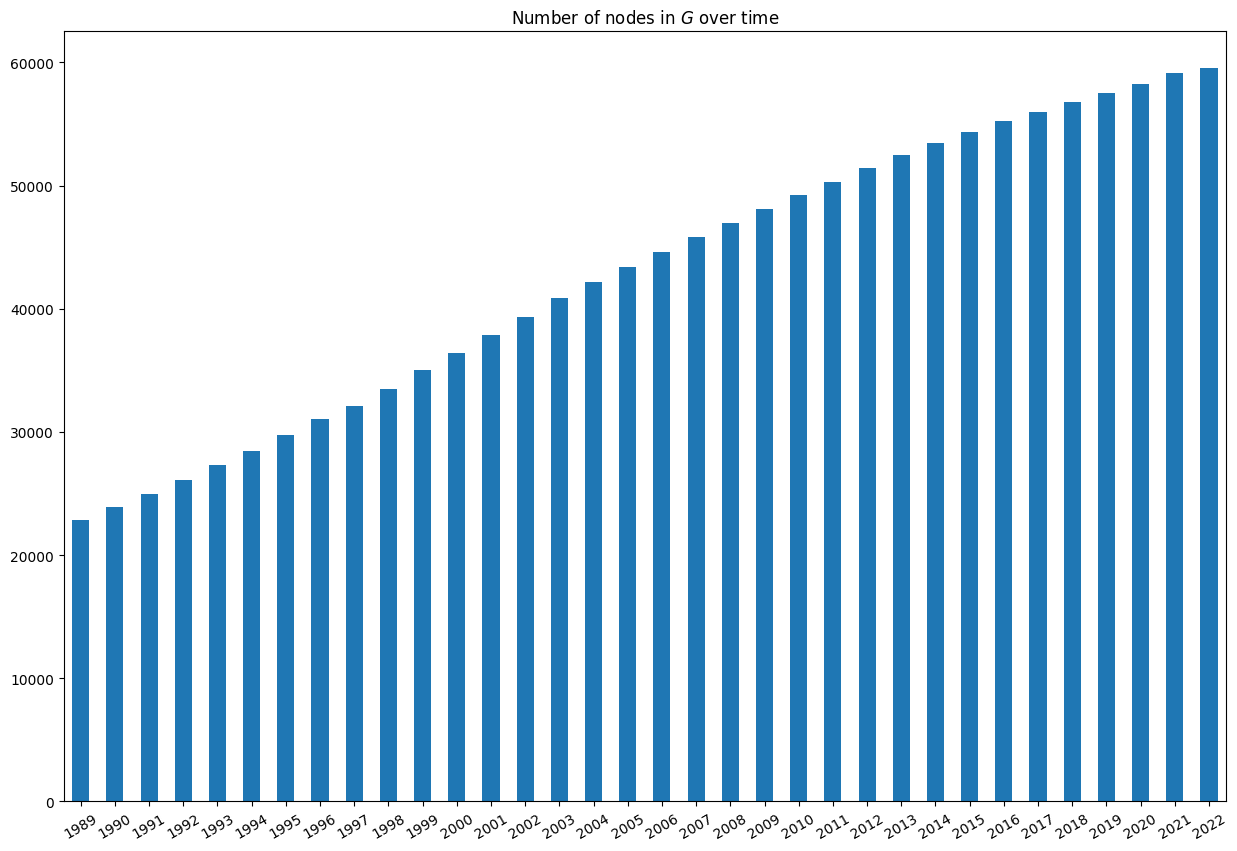

In [26]:
tx_graphs_size_df['nodes'].plot(kind='bar', figsize=(15,10))
plt.xticks(rotation=30)
plt.title('Number of nodes in $G$ over time')

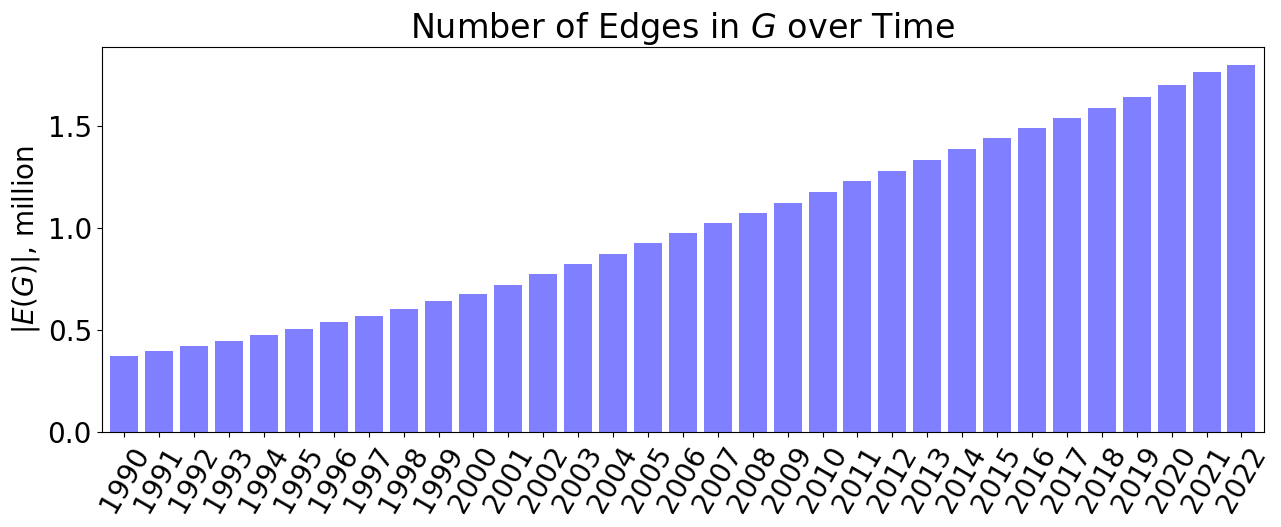

In [43]:
plt.rcParams.update({'font.size': 20})
(
    (tx_graphs_size_df['edges']/1_000_000)
        .loc[1990:]
        .plot(
            kind='bar',
            figsize=(15,5),
            color='blue',
            alpha=0.5,
            width=0.8,
        )
)
plt.xticks(rotation=60)
plt.title('Number of Edges in $G$ over Time')
plt.ylabel('$|E(G)|$, million')
plt.savefig('saved_figures/res_n_edges_over_time.pdf', bbox_inches='tight')